<h3>Model - Logistic Regression</h3>

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score,precision_score,f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

import cleaning
import models

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', 999)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# !pip install imblearn

<h4>Model1</h4>

In order to fit a logistic regression, we need to transform categorical data series to dummy data series (1 or 0). 
Here we will fit the model using the past payments data in amount rather than % so we drop the %s. We also drop the arrears data as we applied grouping to 3m arrears or later due to small sample size.

We then scale the data using the MinMaxScaler before fitting the model.

Note in the data we have imbalance classes of a lot more non-default data than default data, hence in the logistic regression we have put in parameter { class_weight='balanced' } to resolve for this imbalance. 

In terms of the evaluation metric we will focus on for our model, we have chosen recall. As the business case of a credit default model is to correctly identifying the "bad" customers that will default, and recall score gives out of all the actual defaulted customers, how many have our model predicted correctly. We will look at accuracy but it's worth to note that due to the high % of non-default customers (around 78%), if we build a very bad model that puts everyone as "good" it will still give us an high accuracy rate of 80%.

We will also look at AUC (area under curve from the ROC curve), which is a performance measurement for classification problem at various thresholds settings. This tells us how much our model is capable of distinguishing between classes.

In order to find the best hyperparameter we use grid search to try to improve the model result, while checking that our best model is not subject to overfitting.



In [28]:
df = cleaning.clean_raw()

In [29]:
# data transformation for model
df.drop(columns=['pay_0','pay_2', 'pay_3', 'pay_4','pay_5','pay_6'], inplace=True)
df.drop(columns=['pay%_1','pay%_2', 'pay%_3', 'pay%_4','pay%_5'], inplace=True)

# we split the arrears data as it contains some -2 and -1 which we think are all paid on time or not used card
for i in range(1,7):
    df[f'early_{i}'] = df[f'arrears_{i}'].apply(lambda x: 1 if x <= 0 else 0)
    df[f'late_{i}']= df[f'arrears_{i}'].apply(lambda x: x if x > 0 else 0)
    
df.drop(columns=['arrears_1','arrears_2', 'arrears_3', 'arrears_4','arrears_5','arrears_6'], inplace=True)

arr = []
for i in range(1,7):
    arr.append(f'early_{i}')

x_feats = ['sex', 'education', 'marriage'] + arr

In [30]:
# get dummy variables for catagorical data and set X, y
X = pd.get_dummies(df, columns=x_feats, drop_first=True)
X.drop(columns=['default'], inplace=True)
# X.drop(columns=['bill_amt2','bill_amt3','bill_amt4','bill_amt5','bill_amt6'], inplace=True)

y = df['default']

In [31]:
# train test split, test being 30% of dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = MinMaxScaler()

# scale your X
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)


In [32]:
# # calling SMOTE, statistical technique for increasing the number of cases in the dataset in a balanced way
# sm = SMOTE(random_state = 2)
# X_train_res, y_train_res = sm.fit_sample(X_train_scale, y_train.ravel())

<h5>Model Fitting and Results</h5>

Accuracy is :0.7728
Recall is :0.5625
Precision is :0.4843
F1 score is :0.5205

AUC is :0.753


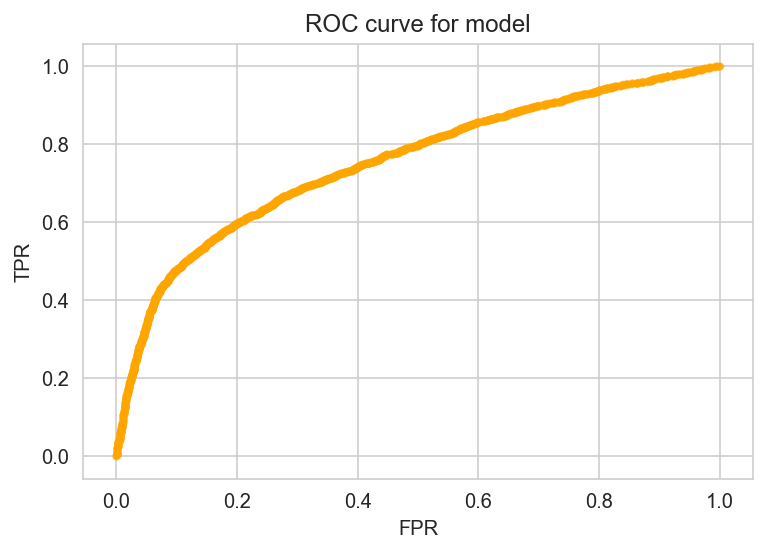

In [33]:
# call function to run logistic refression model, train test split is included in function
acc, recall, roc_auc, ftr, tpr, conf_matrix, logreg = models.log_reg(
    X_train_scale, X_test_scale,
    y_train, y_test,
    0.1,'l1');

In [34]:
# call function to get the best params for the log reg model
best_c, best_pen, best_models = models.grid_search(X_train_scale, y_train, score = 'recall', cv=3)

In [11]:
# the best 5 models, in the last columns we check if the model is overfitting by checking the diff of train and test
best_models.sort_values('rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,split0_drop,split1_drop,split2_drop,avg_drop,overfit
24,4.351653,0.382689,0.006027,0.001665,11.2884,l1,"{'C': 11.288378916846883, 'penalty': 'l1'}",0.380952,0.348777,0.353698,0.361142,0.014151,1,0.346092,0.367321,0.370978,0.361464,0.010971,-0.034860,0.018543,0.017280,0.000321,0
29,0.427436,0.018505,0.004588,0.000496,78.476,l2,"{'C': 78.47599703514607, 'penalty': 'l2'}",0.380309,0.349421,0.353055,0.360928,0.013784,2,0.346092,0.367964,0.370978,0.361678,0.011089,-0.034217,0.018543,0.017923,0.000750,0
28,3.489013,0.306974,0.003540,0.000450,78.476,l1,"{'C': 78.47599703514607, 'penalty': 'l1'}",0.380309,0.349421,0.352412,0.360714,0.013910,3,0.346092,0.366999,0.371943,0.361678,0.011204,-0.034217,0.017578,0.019532,0.000964,0
35,0.437357,0.121775,0.003625,0.000473,1438.45,l2,"{'C': 1438.44988828766, 'penalty': 'l2'}",0.380309,0.349421,0.352412,0.360714,0.013910,3,0.346414,0.366999,0.371943,0.361785,0.011055,-0.033895,0.017578,0.019532,0.001072,0
20,1.822953,0.225697,0.003979,0.000377,1.62378,l1,"{'C': 1.623776739188721, 'penalty': 'l1'}",0.379022,0.346847,0.356270,0.360713,0.013506,5,0.346735,0.366356,0.369691,0.360927,0.010127,-0.032287,0.019509,0.013421,0.000214,0


In [12]:
round(best_c,2), best_pen

(11.29, 'l1')

Accuracy is :0.7673
Recall is :0.5686
Precision is :0.4742
F1 score is :0.5171

AUC is :0.759


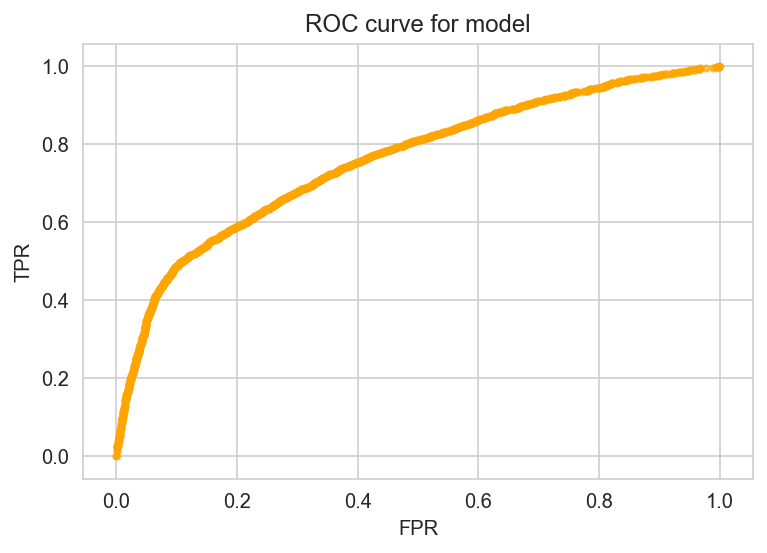

In [13]:
# see the AUC based on test data with best params found before
acc, recall, roc_auc, ftr, tpr, conf_matrix, logreg =  models.log_reg(
    X_train_scale,X_test_scale,y_train, y_test,best_c, best_pen);

In [14]:
conf_matrix

Predicted,0,1,All
True,,,
0,5771,1241,7012
1,849,1119,1968
All,6620,2360,8980


The best hyperparameter to produce the highest AUC on the training data is C = 11.28, penality = 'l1'.

L1 penalise for the sum the absolute value of the coefficients, and in turn performs feature selection by producing near zero values as the coef for unimportant features. 

Parameter C is the the inverse of regularization strength (1/lambda), the higher the C, the lower the strength of regularization. 

Before we put in parameter { class_weight='balanced' } in the logistic regression model we were able to get a 0.82 accuracy, while this is high considering the imbalanced default counts in the data this is not very impressive. Also the recall score was only 0.36. In our model above we have managed to get this to 0.57 recall score.

<h4>Study the model coef</h4>

Here we look to extract the coefficients from the best logistic regression model and try to interpret it.

In [15]:
# assign the coef from the best model above
coef = logreg.coef_
model_result = pd.DataFrame(coef.reshape(-1, len(coef)), index=X_train.columns, columns=['coef_value'])

In [16]:
# add a column that only looks at the magnitude/affect of the coef not the direction
model_result['coef_abs'] = model_result['coef_value'].apply(lambda x: np.abs(x))

In [17]:
model_result.sort_values('coef_abs', ascending=False).head(10)

,coef_value,coef_abs
pay_amt2,-19.510715,19.510715
bill_amt3,6.215963,6.215963
pay_amt1,-4.501351,4.501351
late_1,3.819013,3.819013
limit_bal,-1.998119,1.998119
bill_amt1,-1.769816,1.769816
arrears_1,-1.539115,1.539115
bill_amt2,1.390791,1.390791
late_3,-1.379406,1.379406
bill_amt6,-1.337722,1.337722


It seems like payments data negatively affects the odds of default which makes sense as a bigger payment means less balanced (debt) and hence less chance to default. While a larger balance increase the odds to default.

No of months in arrears at previous ago is increases the loglikelihood of default, however note the same variable 3 months ago, has the opposite effect. This could suggest relying on old payment behaviour is not relevent in predicting.

Also, looking at the above result for the variables with the highest coef, its not the arrears with status 2, 3, but rather payments data, in particular recent payments data. Ituitively speaking, it would make more sense to use recent payments as a % of the outstanding balance rather than amounts. Hence we will do this for the next model to see if we can improve the model.

<h4>Model 2 - Feature Engineering: Using Payments as a % of balance rather than amount </h4>

We need to do some extra data cleaning as the payments as  % of balance data contains some NaN(where balance was 0), and some inf values.

We then proceed to carry out model fitting and grid search to find best hyperparameter.

In [18]:
df2 = cleaning.clean_raw()

In [19]:

df2.drop(columns=['pay_0','pay_2', 'pay_3', 'pay_4','pay_5','pay_6'], inplace=True)
df2.drop(columns=['pay_amt1','pay_amt2', 'pay_amt3', 'pay_amt4','pay_amt5'], inplace=True)

# we split the arrears data as it contains some -2 and -1 which we think are all paid on time or not used card
for i in range(1,7):
    df2[f'early_{i}'] = df2[f'arrears_{i}'].apply(lambda x: 1 if x <= 0 else 0)
    df2[f'late_{i}']= df2[f'arrears_{i}'].apply(lambda x: x if x > 0 else 0)

df2.drop(columns=['arrears_1','arrears_2', 'arrears_3', 'arrears_4','arrears_5','arrears_6'], inplace=True)

arr = []
for i in range(1,7):
    arr.append(f'early_{i}')

x_feats = ['sex', 'education', 'marriage'] + arr

In [20]:
df2.replace([np.inf, -np.inf], np.nan,inplace=True)

# around 3k to 4k of rows with NaN pay%_ missing as balance was zero for these
df2.dropna(axis=0, inplace=True)

In [21]:
X2 = pd.get_dummies(df2, columns=x_feats, drop_first=True)
X2.drop(columns=['default'], inplace=True)
y2 = df2['default']

In [22]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

scaler = MinMaxScaler()

# scale your X
X2_train_scale = scaler.fit_transform(X2_train)
X2_test_scale = scaler.transform(X2_test)

Accuracy is :0.8045
Recall is :0.5663
Precision is :0.5512
F1 score is :0.5586

AUC is :0.784


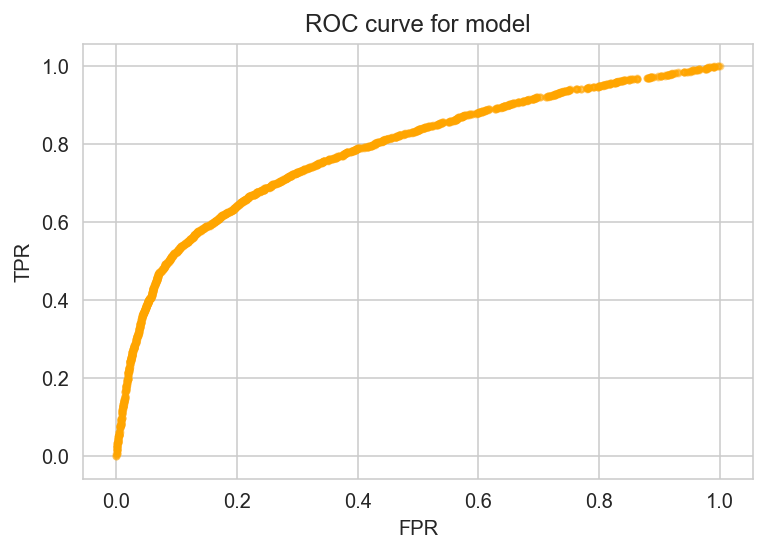

In [23]:
# taking the best c from last model as a base
models.log_reg(X2_train_scale,X2_test_scale,y2_train, y2_test, 0.2,'l1');

In [24]:
# call function to get the best params for the log reg model
best_c2, best_pen2, best_clf2 = models.grid_search(X2_train_scale, y2_train, score = 'recall', cv=3)

In [25]:
best_c2, best_pen2

(78.47599703514607, 'l1')

//anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy is :0.8012
Recall is :0.5682
Precision is :0.543
F1 score is :0.5553

AUC is :0.784


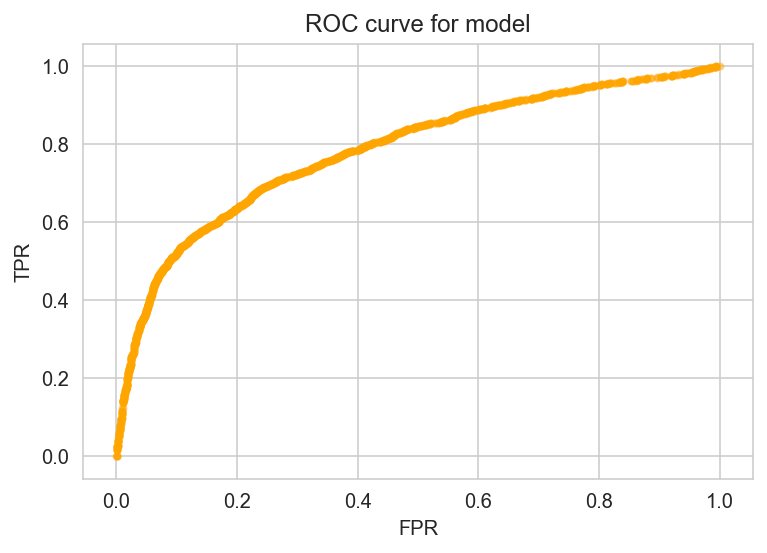

In [26]:
# See the Performance of the final model using test dataset
acc, recall, roc_auc, ftr, tpr, conf_matrix, logreg = models.log_reg(
    X2_train_scale,X2_test_scale,y2_train, y2_test,best_c2,best_pen2);

Our final model with the feature engineering have produced a recall of 56.8%, accuracy of 80.1% and AUC of 78.4%


In [52]:
# assign the coef from the best model above
coef = logreg.coef_
model_result = pd.DataFrame(coef.reshape(-1, len(coef)), index=X2_train.columns, columns=['coef_value'])

# add a column that only looks at the magnitude/affect of the coef not the direction
model_result['coef_abs'] = model_result['coef_value'].apply(lambda x: np.abs(x))

In [53]:
model_result.sort_values('coef_abs', ascending=False).head(10)

,coef_value,coef_abs
pay%_2,7.352393,7.352393
pay%_5,-4.917877,4.917877
pay%_1,4.316830,4.316830
late_1,4.139994,4.139994
bill_amt1,2.987960,2.987960
limit_bal,-2.814718,2.814718
arrears_1,-2.438891,2.438891
late_6,2.294350,2.294350
pay_amt6,-2.230674,2.230674
pay%_4,-2.102355,2.102355
